In [1]:
# -------- Code Outline -------- #
# Code implements the pan tompkins peak detection algorithm
# Copied from github Pickus91/HRV
# Use to test CWT, data segmenter, poincare plots
# ANN's, until we have a working peak detector

In [2]:
# -------- Loader -------- #
# We import the raw data here as the Pan-Tompkins algorithm has its own
# Filtering method which we follow. End goal will be to implement our own
# Filtering method and combine this with the Pan-Tompkins algorithm however,
# So far this has proved to be unsuccessful

import pickle
with open('Raw Data/afdb_arrays/4015.pkl', 'rb') as f:
    Data = pickle.load(f)

In [3]:
# -------- Pan Tompkins algorithm -------- #
# Implement Pan Tompkins algorithm with the original recommended
# Filtering requirements

import numpy as np
from matplotlib import style
from scipy import signal
import matplotlib.pyplot as plt 
style.use('ggplot')

def panTompkins(ECG, fs, plot = 1): 
    """
    Inputs:
    - ECG   : [list] | [numpy.ndarray] of ECG samples
    - fs    : [int] sampling frequency
    - plot  : [1|0] optional plot of R-peak detections overlayed on ECG signal
    Outputs:
    - Rpeaks : [list] of integers indicating R peak sample number locations
    """    
    if type(ECG) == list or type(ECG) is np.ndarray:
        ECG = np.array(ECG)             
        
    #Initialize
    RRAVERAGE1 = []
    RRAVERAGE2 = []
    IWF_signal_peaks = []
    IWF_noise_peaks = []
    noise_peaks = []
    ECG_bp_peaks = np.array([])
    ECG_bp_signal_peaks = []
    ECG_bp_noise_peaks = []
    final_R_locs = []
    T_wave_found = 0      
    
    #LOW PASS FILTERING
    #Transfer function: H(z)=(1-z^-6)^2/(1-z^-1)^2
    a = np.array([1, -2, 1])
    b = np.array([1, 0, 0, 0, 0, 0, -2, 0, 0, 0, 0, 0, 1])   
        
    impulse = np.repeat(0., len(b)); impulse[0] = 1.    
    impulse_response = signal.lfilter(b,a,impulse)
    
    #convolve ECG signal with impulse response
    ECG_lp = np.convolve(impulse_response, ECG)
    ECG_lp = ECG_lp / (max(abs(ECG_lp)))
    delay = 12 #full convolution
    
    #HIGH PASS FILTERING
    #Transfer function: H(z)=(-1+32z^-16+z^-32)/(1+z^-1)
    a = np.array([1, -1])           
    b = np.array([-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 32, -32, 0, 0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 0, 0, 0, -1])
                  
    impulse = np.repeat(0., len(b)); impulse[0] = 1.    
    impulse_response = signal.lfilter(b,a,impulse)
    
    ECG_lp_hp = np.convolve(impulse_response, ECG_lp)
    ECG_lp_hp = ECG_lp_hp/(max(abs(ECG_lp_hp)))
    delay = delay + 32 
    
    #BAND PASS FILTER 
    nyq = fs / 2        
    lowCut = 5 / nyq  #cut off frequencies are normalized from 0 to 1, where 1 is the Nyquist frequency
    highCut = 15 / nyq
    order = 5
    b,a = signal.butter(order, [lowCut, highCut], btype = 'bandpass')
    ECG_bp = signal.lfilter(b, a, ECG_lp_hp)
    
    #DIFFERENTIATION
    #Transfer function: H(z)=(1/8T)(-z^-2-2z^-1+2z^1+z^2)
    T = 1/fs
    b = np.array([-1, -2, 0, 2, 1]) * (1 / (8 * T))
    a = 1
    #Note impulse response of the filter with a = [1] is b
    ECG_deriv = np.convolve(ECG_bp, b)
    delay = delay + 4 
    
    #SQUARING FUNCTION
    ECG_squared = ECG_deriv ** 2
    
    #MOVING INTEGRATION WAVEFORM 
    N = int(np.ceil(0.150 * fs)) 
    ECG_movavg = np.convolve(ECG_squared,(1 / N) * np.ones((1, N))[0])
    
    #FUDICIAL MARK ON MOVING INTEGRATION WAVEFORM
    peaks = findPeaks(ECG_movavg)
    
    #LEARNING PHASE 1   
    #2 second initialize phase for MIW, 25% of max amplitude considered signal, 50% of mean signal considered noise
    initializeTime = 2 * fs 
    SPKI = max(ECG_movavg[:initializeTime]) * 0.25 
    NPKI = np.mean(ECG_movavg[:initializeTime]) * 0.5 
    THRESHOLDI1 = NPKI + 0.25 * (SPKI-NPKI)
    THRESHOLDI2 = 0.5 * THRESHOLDI1 
    
    #2 second initialize for filtered signal, 25% of max amplitude considered signal, 50% of mean signal considered noise
    initializeTime = 2 * fs 
    SPKF = max(ECG_bp[:initializeTime]) * 0.25 
    NPKF = np.mean(ECG_bp[:initializeTime]) * 0.5 
    THRESHOLDF1 = NPKF + 0.25 * (SPKF-NPKF)
    THRESHOLDF2 = 0.5 * THRESHOLDF1
    
    peaks = peaks[peaks > initializeTime] #ignore peaks that occur during initialization window

    for c,peak in enumerate(peaks):
        
        print(c) # See which peak we are on
        
        #find corresponding peaks in filtered ECG using neighborhood search window +- 0.15 seconds       
        searchInterval = int(np.round(0.15 * fs))
        searchIndices = np.arange(peak - searchInterval, peak + searchInterval + 1, 1)        
        #neighborhood search indices cannot be negative and cannot exceed length of filtered ECG
        if searchIndices[0] >= 0 and all(searchIndices <= len(ECG_bp)):            
             ECG_bp_peaks = np.append(ECG_bp_peaks, np.where(ECG_bp == max(ECG_bp[searchIndices]))[0][0])          
        else:
             ECG_bp_peaks = np.append(ECG_bp_peaks, np.where(ECG_bp == max(ECG_bp[searchIndices[0]:len(ECG_bp)-1])))
        #LEARNING PHASE 2
        if c > 0 and c < len(ECG_bp_peaks):                     
            if c < 8:                
                RRAVERAGE1_vec = np.diff(peaks[:c + 1]) / fs
                RRAVERAGE1_mean = np.mean(RRAVERAGE1_vec)
                RRAVERAGE1.append(RRAVERAGE1_mean) 
                
                RR_LOW_LIMIT = 0.92 * RRAVERAGE1_mean
                RR_HIGH_LIMIT = 1.16 * RRAVERAGE1_mean
                RR_MISSED_LIMIT = 1.66 * RRAVERAGE1_mean                   
            else:                
                RRAVERAGE1_vec = np.diff(peaks[c - 8:c + 1]) / fs
                RRAVERAGE1_mean = np.mean(RRAVERAGE1_vec)
                RRAVERAGE1.append(RRAVERAGE1_mean) 
    
                for rr in np.arange(0, len(RRAVERAGE1_vec)):
                    if RRAVERAGE1_vec[rr] > RR_LOW_LIMIT and RRAVERAGE1_vec[rr] < RR_HIGH_LIMIT:                              
                        RRAVERAGE2.append(RRAVERAGE1_vec[rr])                                     
                        if len(RRAVERAGE2) > 8:
                            del RRAVERAGE2[:len(RRAVERAGE2) - 8]
    
                if len(RRAVERAGE2) == 8:
                    RR_LOW_LIMIT = 0.92 * np.mean(RRAVERAGE2)        
                    RR_HIGH_LIMIT = 1.16 * np.mean(RRAVERAGE2)
                    RR_MISSED_LIMIT = 1.66 * np.mean(RRAVERAGE2)
            #If irregular heart beat detected in previous 9 beats, lower signal thresholds by half to increase detection sensitivity            
            current_RR_movavg = RRAVERAGE1[-1] 
            if current_RR_movavg < RR_LOW_LIMIT or current_RR_movavg > RR_MISSED_LIMIT: 
                #MIW thresholds        
                THRESHOLDI1 = 0.5 * THRESHOLDI1
                THRESHOLDI2 = 0.5 * THRESHOLDI1
                #Filtered ECG thresholds
                THRESHOLDF1 = 0.5 * THRESHOLDF1
                THRESHOLDF2 = 0.5 * THRESHOLDF1
               
            #Search back triggered if current RR interval is greater than RR_MISSED_LIMIT
            currentRRint = RRAVERAGE1_vec[-1]
            if currentRRint > RR_MISSED_LIMIT:  
                SBinterval = int(np.round(currentRRint * fs))
                #find local maximum in the search back interval between signal and noise thresholds                        
                SBdata_IWF = ECG_movavg[peak - SBinterval + 1:peak + 1]               
                
                SBdata_IWF_filtered = np.where((SBdata_IWF > THRESHOLDI1))[0]
                SBdata_max_loc = np.where(SBdata_IWF == max(SBdata_IWF[SBdata_IWF_filtered]))[0][0]

                if len(SBdata_IWF_filtered) > 0:   
                    SB_IWF_loc = peak - SBinterval + 1 + SBdata_max_loc
                    IWF_signal_peaks.append(SB_IWF_loc) 
                    #update signal and noise thresholds
                    SPKI = 0.25 * ECG_movavg[SB_IWF_loc] + 0.75 * SPKI                         
                    THRESHOLDI1 = NPKI + 0.25 * (SPKI - NPKI)
                    THRESHOLDI2 = 0.5 * THRESHOLDI1               
                    #finding corresponding search back peak in ECG bandpass using 0.15 s neighborhood search window
                    if SB_IWF_loc < len(ECG_bp):
                        SBdata_ECGfilt = ECG_bp[SB_IWF_loc - round(0.15 * fs): SB_IWF_loc]                    
                        SBdata_ECGfilt_filtered = np.where((SBdata_ECGfilt > THRESHOLDF1))[0]
                        SBdata_max_loc2 = np.where(SBdata_ECGfilt == max(SBdata_ECGfilt[SBdata_ECGfilt_filtered]))[0][0]
                                     
                    else:
                        SBdata_ECGfilt = ECG_bp[SB_IWF_loc - round(0.15 * fs):]
                        SBdata_ECGfilt_filtered = np.where((SBdata_ECGfilt > THRESHOLDF1))[0]
                        SBdata_max_loc2 = np.where(SBdata_ECGfilt == max(SBdata_ECGfilt[SBdata_ECGfilt_filtered]))[0][0]

                            
                    if ECG_bp[SB_IWF_loc - round(0.15 * fs) + SBdata_max_loc2] > THRESHOLDF2: #QRS complex detected in filtered ECG
                        #update signal and noise thresholds                                                          
                        SPKF = 0.25 * ECG_bp[SB_IWF_loc - round(0.15 * fs) + SBdata_max_loc2] + 0.75 * SPKF                            
                        THRESHOLDF1 = NPKF + 0.25 * (SPKF - NPKF)
                        THRESHOLDF2 = 0.5 * THRESHOLDF1                            
                        ECG_bp_signal_peaks.append(SB_IWF_loc - round(0.15 * fs) + SBdata_max_loc2)                                                 
    
            #T-WAVE AND QRS DISRCIMINATION    
            if ECG_movavg[peak] >= THRESHOLDI1: 
                if currentRRint > 0.20 and currentRRint < 0.36 and c > 0: 
                    #Slope of current waveform (possible T wave)
                    #mean width of QRS complex: 0.06 - 0.10 sec         
                    maxSlope_current = max(np.diff(ECG_movavg[peak - round(fs * 0.075):peak + 1]))
                    #slope of the waveform (most likely QRS) that preceeded it
                    maxSlope_past = max(np.diff(ECG_movavg[peaks[c - 1] - round(fs * 0.075): peaks[c - 1] + 1]))
                    if maxSlope_current < 0.5 * maxSlope_past: #T-wave found                        
                        T_wave_found = 1                
                        #keep track of peaks marked as 'noise'
                        IWF_noise_peaks.append(peak)                
                        #update Noise levels
                        NPKI = 0.125 * ECG_movavg[peak] + 0.875 * NPKI                                            
                               
                if not T_wave_found: #current peak is a signal peak                    
                    IWF_signal_peaks.append(peak)
                    #adjust signal levels
                    SPKI = 0.125 * ECG_movavg[peak]  + 0.875 * SPKI
                    #check if corresponding peak in filtered ECG is also a signal peak                        
                    if ECG_bp_peaks[c] > THRESHOLDF1:                                            
                        SPKF = 0.125 * ECG_bp[c] + 0.875 * SPKF 
                        ECG_bp_signal_peaks.append(ECG_bp_peaks[c])                             
                    else:
                        ECG_bp_noise_peaks.append(ECG_bp_peaks[c])
                        NPKF = 0.125 * ECG_bp[c] + 0.875 * NPKF                   
                                        
            elif ECG_movavg[peak] > THRESHOLDI1 and ECG_movavg[peak] < THRESHOLDI2:
                #update noise thresholds
                NPKI = 0.125 * ECG_movavg[peak]  + 0.875 * NPKI  
                NPKF = 0.125 * ECG_bp[c] + 0.875 * NPKF
                    
            elif ECG_movavg[peak] < THRESHOLDI1:
                #update noise thresholds
                noise_peaks.append(peak)
                NPKI = 0.125 * ECG_movavg[peak]  + 0.875 * NPKI            
                ECG_bp_noise_peaks.append(ECG_bp_peaks[c])                       
                NPKF = 0.125 * ECG_bp[c] + 0.875 * NPKF
        else:
            if ECG_movavg[peak] >= THRESHOLDI1: #first peak is a signal peak
                IWF_signal_peaks.append(peak) 
                #update signal  thresholds
                SPKI = 0.125 * ECG_movavg[peak]  + 0.875 * SPKI
                if ECG_bp_peaks[c] > THRESHOLDF1:                                            
                    SPKF = 0.125 * ECG_bp[c] + 0.875 * SPKF 
                    ECG_bp_signal_peaks.append(ECG_bp_peaks[c])                             
                else:
                    ECG_bp_noise_peaks.append(ECG_bp_peaks[c])
                    NPKF = 0.125 * ECG_bp[c] + 0.875 * NPKF                                    
                
            elif ECG_movavg[peak] > THRESHOLDI2 and ECG_movavg[peak] < THRESHOLDI1:
                #update noise thresholds
                NPKI = 0.125 * ECG_movavg[peak]  + 0.875 * NPKI  
                NPKF = 0.125 * ECG[c] + 0.875 * NPKF
                                    
            elif ECG_movavg[peak] < THRESHOLDI2:
                #update noise thresholds
                noise_peaks.append(peak)
                NPKI = 0.125 * ECG_movavg[peak]  + 0.875 * NPKI            
                ECG_bp_noise_peaks.append(ECG_bp_peaks[c])                       
                NPKF = 0.125 * ECG_bp[c] + 0.875 * NPKF       
            
                    
        #reset 
        T_wave_found = 0                
            
        #update thresholds
        THRESHOLDI1 = NPKI + 0.25 * (SPKI - NPKI)
        THRESHOLDI2 = 0.5 * THRESHOLDI1 
            
        THRESHOLDF1 = NPKF + 0.25 * (SPKF - NPKF)
        THRESHOLDF2 = 0.5 * THRESHOLDF1
    
    #adjust for filter delays
    ECG_R_locs = [int(i - delay) for i in ECG_bp_signal_peaks]
    ECG_R_locs = np.unique(ECG_R_locs)
    
    #neighborhood search in raw ECG signal for increase accuracy of R peak detection    
    for i in ECG_R_locs:
        ECG = np.array(ECG)
        searchInterval = int(np.round(0.02 * fs))
        searchIndices = np.arange(i - searchInterval, i + searchInterval + 1, 1)
        searchIndices = [i.item() for i in searchIndices] #convert to native Python int
        final_R_locs.append(np.where(ECG[searchIndices] == max(ECG[searchIndices]))[0][0] + searchIndices[0])
    
    #plot ECG signal with R peaks marked
    if plot == 1:
        samples = np.arange(0, len(ECG))
        plt.plot(samples, ECG, c = 'b')        
        plt.scatter(final_R_locs, ECG[final_R_locs], c = 'r', s = 30)
        plt.xlabel('Sample')
        plt.ylabel('ECG')
    else:
        pass
        
    return final_R_locs
                    
def findPeaks(ECG_movavg):
    """finds peaks in Integration Waveform by smoothing, locating zero crossings, and moving average amplitude thresholding"""
    #smoothing
    N = 15
    ECG_movavg_smooth = np.convolve(ECG_movavg, np.ones((N,)) / N, mode = 'same')    
    #signal derivative    
    sigDeriv = np.diff(ECG_movavg_smooth)     
    #find location of zero-crossings
    zeroCross = []
    for i,c in enumerate(np.arange(len(sigDeriv)-1)):
        if sigDeriv[i] > 0 and sigDeriv[i + 1] < 0:
            zeroCross.append(c)           
    print(len(zeroCross))
    return np.array(zeroCross) 


105461


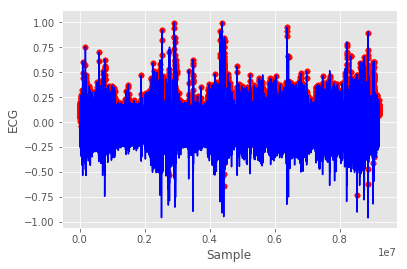

In [4]:
# -------- Function Call -------- #
# We now call this function however note that this takes a very long
# Time depending on computer details. (For us it took half an hour per
# Data set). Optimising for speed will be in best interests for clinical
# Applications

r_peaks = panTompkins(Data, 250, plot = 1)

In [5]:
# -------- Saver -------- #
# Save the peak locations as an array and export

# Now that we have R-Peaks we can extract them as pickle file

filename = '4015_Pickus_R_Peaks'

# This line uses pickle to save the peak array as a .pkl file

with open('{}.pkl'.format(filename), 'wb') as f:
     pickle.dump(r_peaks, f)